In [86]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [87]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [88]:
## 평가모듈
import evaluation_module as evm

## Data

In [159]:
df_ori = pd.read_csv('data/data_prep.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

In [160]:
ML_res = pd.read_csv('data/result_ML.csv')
ML_res['time'] = pd.to_datetime(ML_res['time'])
ML_res = ML_res.set_index('time')

In [161]:
dataset = df_ori.copy()
dataset['hat'] = ML_res['hat'].dropna()
dataset = dataset.dropna()

dataset['spread_ratio'] = dataset['spread']/dataset['vwap_near']

In [162]:
## 이론적 스프레드비율
temp = dataset.drop_duplicates(subset='epi_no', keep='last')
cri_min = temp['spread_ratio'].min()
cri_max = temp['spread_ratio'].max()

In [163]:
## 룰베이스 BM용
temp_mean = dataset['spread_ratio'][:test_split].mean()
temp_std = dataset['spread_ratio'][:test_split].std()

cri_ustd = temp_mean + 1*temp_std
cri_lstd = temp_mean - 1*temp_std

In [164]:
## Test index
test_split = df_ori[df_ori['epi_no'] > 8].index[0]
test_split

Timestamp('2019-12-27 12:00:00')

## 전략구현

* 예측 스프레드가 현재 스프레드보다 낮을 때는 매도포지션
* 예측 스프레드가 현재 스프레드보다 높을 때는 매수포지션
* 당분기물 만기시점에는 중립
* pre_pos: 전기 포지션  
  - 전기 포지션을 표시하여 전기 표지션을 통해서 현재 얻은 수익을 산출하기 위함
* 주의사항: 거래비용은 고려하지 않음

* 전략 리스트  
  - ML_p1: 스프레드매도 기회만 활용하는 전략
  - ML_p2: 스프레드매수매도 기회를 모두 활용하는 전략
  - ML_p2_v2: 이론적(역사적) 스프레드비율 외구간에서만 매수매도 기회를 활용하는 전략
* Bench Mark  
  - 당분기 선물 Buy&Hold
  - 스프레드비율 2표준편차 외구간에서만 매수매도하는 전략

In [165]:
dataset['pre_pos'] = 0
dataset['pre_pos'][dataset['hat'].shift(-1) > dataset['spread']] = 1
dataset['pre_pos'][dataset['hat'].shift(-1) < dataset['spread']] = -1
dataset['pre_pos'][dataset['duetime'] == 0] = 0
dataset['pre_pos'] = dataset['pre_pos'].shift(1)

In [166]:
dataset['pre_pos_BM2'] = 0
dataset['pre_pos_BM2'][dataset['spread_ratio'] > cri_ustd] = -1
dataset['pre_pos_BM2'][dataset['spread_ratio'] < cri_ustd] = 1
dataset['pre_pos_BM2'] = dataset['pre_pos_BM2'].shift(1)

In [167]:
## 항상 매수포지션일 때의 수익률
## 스프레드차익/(매수증거금+매도증거금)
dataset['rets'] = ((dataset['spread'] - dataset['spread'].shift(1))/
                   (dataset['vwap_near']+dataset['vwap_longer']).shift(1))

In [168]:
## 예측모형을 활용한 양측 매매 전략
dataset['ML_p2'] = dataset['rets'] * dataset['pre_pos']

## 예측모형을 활용한 단측 매도 전략
## 오직 매도기회에 매도만하는 전략
dataset['ML_p1'] = dataset['ML_p2'].copy()
dataset['ML_p1'][dataset['pre_pos']>= 0] = 0

## 이론적 스프레드비율을 임계점으로 활용하는 전략
dataset['ML_p2_v2'] = dataset['ML_p2'].copy()
dataset['ML_p2_v2'][(dataset['spread_ratio'].shift(1) <= cri_max)&(dataset['spread_ratio'].shift(1) >= cri_min)] = 0

## BM1: 당분기물 Buy&Hold 롤오버는 고려하지 않음
dataset['BM1'] = dataset['vwap_near'].pct_change()

## BM2 Spread 비율이 2표준편차를 초과할때만 매도매수
dataset['BM2'] = dataset['rets'] * dataset['pre_pos_BM2']

## 전략 평가

In [169]:
rets_ML_p1 = dataset['ML_p1'].dropna()
rets_ML_p2 = dataset['ML_p2'].dropna()
rets_ML_p2_v2 = dataset['ML_p2_v2'].dropna()
rets_BM1 = dataset['BM1'].dropna()
rets_BM2 = dataset['BM2'].dropna()

In [170]:
df_rets = pd.DataFrame([rets_ML_p1, rets_ML_p2, rets_ML_p2_v2, rets_BM1, rets_BM2]).T

### 평가 요약

In [171]:
report = evm.get_report2(df_rets, term='bit')
print('전기간 성능평가')
report
## 분석 초기 과도한 스프레드가 과대 Return으로 나타남
## Trainset이 포함되었으므로 모델 적합만 파악함

전기간 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML_p1,0.2326,0.0836,2.7830,-0.0557,0.7550
ML_p2,0.4265,0.1156,3.6879,-0.1226,0.5083
ML_p2_v2,0.2352,0.0788,2.9843,-0.0781,0.9576
BM1,-0.1589,0.7478,-0.2126,-0.8326,0.5131
BM2,0.2878,0.1163,2.4739,-0.0365,0.5045


In [172]:
report_l3 = evm.get_report2(df_rets[test_split:], term='bit')
print('최근 3분기(Test기간) 성능평가')
report_l3

최근 3분기(Test기간) 성능평가


,Return,Volatility,Sharpe,MDD,Win
ML_p1,0.0895,0.0506,1.7688,-0.0345,0.6895
ML_p2,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_p2_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126
BM2,0.1544,0.0945,1.6335,-0.0365,0.5083


### 자산가치 추이

In [174]:
## GRU1, GRU2만 남김
df_rets_clean = df_rets[['ML_p1', 'ML_p2', 'ML_p2_v2', 'BM1', 'BM2']]

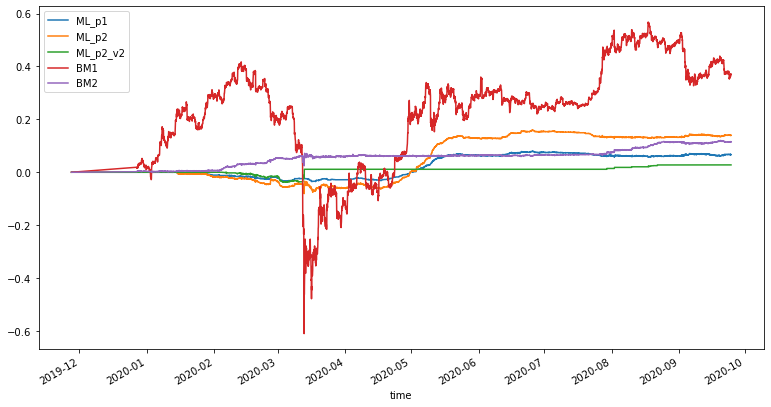

In [175]:
df_value_L3 = evm.get_df_val(df_rets_clean[test_split:])
## Test기간
np.log(df_value_L3).plot()

### MDD

In [176]:
df_dd = evm.get_dd(df_value_L3)

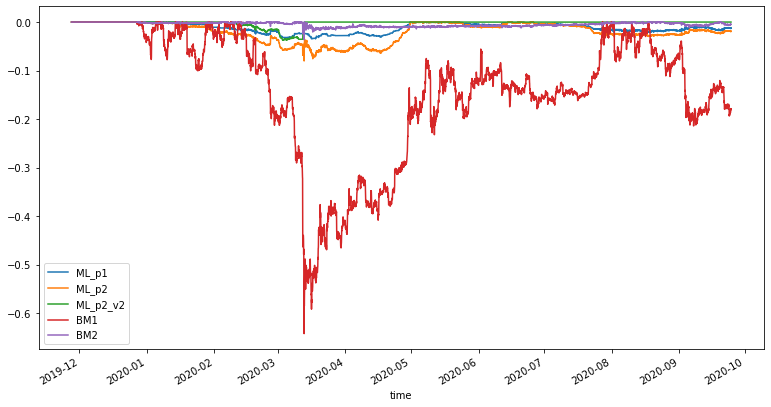

In [177]:
df_dd.plot()

## 결론

In [178]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML_p1,0.0895,0.0506,1.7688,-0.0345,0.6895
ML_p2,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_p2_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126
BM2,0.1544,0.0945,1.6335,-0.0365,0.5083


### 중수익 저위험 만족 전략

  - 중수익 저위험을 어떻게 정의하느냐에 따라 유효한 전략을 판단하는 관점이 다를 수 있음
  - 중수익 저위험을 Return 14%, Volatility 10%로 정의한다면, Test기간에 대해 중수익 저위험을 만족하는 전략은 ML_p2, BM2 전략임
  - 반면 Return 7%, Volatility 5%로 정의한다면, ML_p1 전략이 조건에 만족하는 유일한 전략임

### BM 선정

* BM1
  - BM1은 당분기물 B&H 전략으로 상당한 변동성(73%)에 노출되어 있는 것을 알 수 있음
  - 또한, MDD가 64%수준으로 실제 투자에 적용한다면 상당한 스트레스에 노출될 수 있음

* BM2  
  - BM2는 Train기간 동안의 당분기물대비Spread비(Spread_ratio)를 기준으로 매수매도하는 전략임
  - 평균Spread_ratio 대비 1표준편차를 기준으로 매수매도한 결과 Test기간에 대해 Return, Vol 각각 15%, 9%를 달성하며 꽤나 매력적인 전략임
  - MDD 역시 4%미만으로 준수함

### 전략별 평가

* 예측기반 스프레드매도전략; ML_p1  
  - 수익률, 변동성 각각 9.0%, 5.0% 으로 중수익 저위험을 만족하는 전략으로 볼 수 있음
  - BM2 대비 낮은 수익률과 낮은 변동성으로 높은 Sharpe를 달성함
  - MDD 역시 3.5% 수준으로 준수함
  - 준수한 수익률과 낮은 변동성을 추구하는 투자자가 선택할 수 있는 선택지로 판단됨

* 예측기반 스프레드매수매도전략; ML_p2  
  - 수익률, 변동성 각각 18.7%, 9.4% 으로 ML_p2 대비 높은 수익률과 높은 변동성을 기록함
  - BM2 대비 높은 수익률과 유사한 변동성으로 전략들 중 가장 높은 Sharpe를 달성합
  - MDD는 8.0% 수준임
  - 공격적인 수익률과 중간정도의 변동성을 추구하는 투자자가 선택할 수 있는 선택지임

* 이론적 스프레드에서 거래하지 않는 전략; ML_p2_v2  
  - 이론적 스프레드를 당분기물 결재일 스프레드의 평균값으로 정의함
  - 수익률, 변동성 각각 3.7%, 5.3% 으로 ML_p2 대비 낮은 수익률과 낮은 변동성을 기록함
  - 이론적 스프레드 내에서 거래불가 규칙이 변동성을 낮추는 역할을 함
  - 하지만 유의미한 투자기회를 다수 상실함으로썬 수익률 하락으로 이어짐
  - 그 결과 Sharpe가 0.71 수준으로 떨어짐

### 총평

In [179]:
report_l3

,Return,Volatility,Sharpe,MDD,Win
ML_p1,0.0895,0.0506,1.7688,-0.0345,0.6895
ML_p2,0.1873,0.0943,1.9871,-0.0802,0.5024
ML_p2_v2,0.0373,0.0527,0.7085,-0.0371,0.9473
BM1,0.4978,0.7318,0.6802,-0.6420,0.5126
BM2,0.1544,0.0945,1.6335,-0.0365,0.5083


* 수익률: BM1 > ML_p2 > BM2 > ML_p1 > ML_p2_v2
* 변동성(-): ML_p1 > ML_p2_v2 > ML_p2 > BM2 > BM1
* Sharpe: ML_p2 > ML_p1 > BM2 > ML_p2_v2 > BM1
* MDD: ML_p1 > BM2 > ML_p2_v2 > ML_p2 > BM1

* ML_p1 전략이 BM2 전략 대비 변동성, Sharpe, MDD 측면에서 우세한 전략임
* 중수익 저위험(Return 7%, Volatility 5%) 관점에 부합하는 전략임
* 다만, 기대수익률을 좀 더 높이기 위한 선택지로 ML_p2 전략을 고려할 수 있음

* 기술적 이해  
  - 룰베이스 전략(BM2) 전략에서 ML기반 예측모형을 활용하면 전략의 성능 개선이 나타남
  - 반대로 ML기반 전략에 Rule을 추가했을 때는 전체적인 성능 햐향이 나타남(ML_p2 -> ML_p2_v2)
  - 이는 ML모델링 과정에서 시계열의 정보를 모두 활용한 후 Rule을 추가함으로써 정보를 이중으로 활용했기 때문일 수 있음